In [3]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime
#import gspread as gs

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


In [1]:
#sheet_id = 
#sheet_name = TX
#url = f”https://docs.google.com/spreadsheets/d/1DFA_hu_0QSpqyTCwNIYKrBvglhUI8o0c/gviz/tq?tqx=out:csv&sheet=TX"

SyntaxError: invalid character '”' (U+201D) (766334507.py, line 3)

In [55]:
df=pd.read_excel(r'C:\Users\bantenuc\OneDrive - Ternium\Escritorio\BRUNO\Tesis\PDB.xlsx')
df = df.dropna() # is it ok to drop NaN values??
df=df.reset_index()
df = df.drop('index', axis=1)
#df=df.set_index('Date')
df

,Q,Date,PX_LAST,PX_VOLUME,CUR_MKT_CAP,BS_SH_OUT,EBITDA,TRAIL_12M_EBITDA
0,3Q2007,2007-09-28,31.40,569500.0,6294.8932,267.500,318.4,1603.111
1,4Q2007,2007-10-01,31.77,1409900.0,6369.0686,267.500,318.4,1603.111
2,4Q2007,2007-10-02,31.67,521600.0,6349.0212,267.500,318.4,1603.111
3,4Q2007,2007-10-03,31.46,344200.0,6306.9216,267.500,318.4,1603.111
4,4Q2007,2007-10-04,31.27,173800.0,6268.8315,267.500,318.4,1603.111
...,...,...,...,...,...,...,...,...
3794,4Q2022,2022-10-25,28.84,234094.0,5781.6801,200.474,1224.0,5817.824
3795,4Q2022,2022-10-26,29.09,141321.0,5831.7987,200.474,1224.0,5817.824
3796,4Q2022,2022-10-27,28.94,181497.0,5801.7275,200.474,1224.0,5817.824
3797,4Q2022,2022-10-28,28.49,291000.0,5711.5141,200.474,1224.0,5817.824


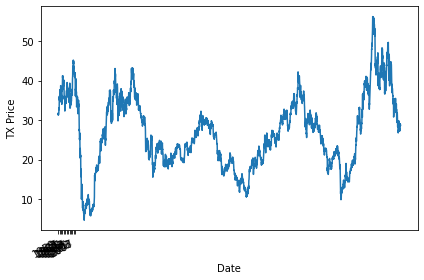

In [58]:
# Plot the time series
fig, ax = plt.subplots()

ax.plot(df['PX_LAST'])
ax.set_xlabel('Date')
ax.set_ylabel('TX Price')

plt.xticks(np.arange(0, 208, 16), np.arange(1959, 2010, 4))

fig.autofmt_xdate()
plt.tight_layout()

In [37]:
#Check for stationarity - ADF is not a large negative number and p-value is greater than 0.05
target = df['PX_LAST']
ADF_result = adfuller(target)
print(f'ADF Statistic: {ADF_result[0]}') 
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -2.89789683396599
p-value: 0.04559311425769313


In [38]:
#Take first difference and check for stationarity

target_diff = target.diff()

ad_fuller_result = adfuller(target_diff[1:])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -13.639353370228978
p-value: 1.6645664565478939e-25


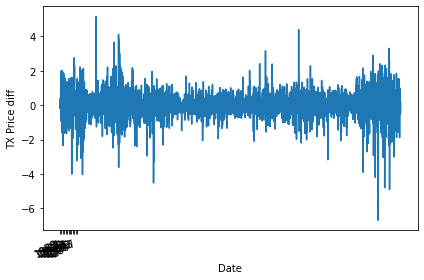

In [39]:
#Plot differenced series
fig, ax = plt.subplots()

ax.plot(target_diff)
ax.set_xlabel('Date')
ax.set_ylabel('TX Price diff')

plt.xticks(np.arange(0, 208, 16), np.arange(1959, 2010, 4))

fig.autofmt_xdate()
plt.tight_layout()

In [46]:
target_diff

0        NaN
1       0.37
2      -0.10
3      -0.21
4      -0.19
        ... 
3794    0.54
3795    0.25
3796   -0.15
3797   -0.45
3798    0.19
Name: PX_LAST, Length: 3799, dtype: float64

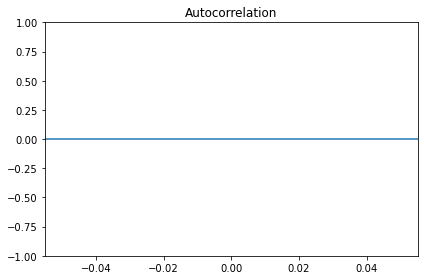

In [40]:
#Plot ACF for differenced series. Not taking as time series

plot_acf(target_diff, lags=30);

plt.tight_layout()


In [41]:
df_diff = pd.DataFrame(target_diff)

train = df_diff[:int(0.9*len(df_diff))]
test = df_diff[int(0.9*len(df_diff)):]

print(len(train))
print(len(test))

3419
380


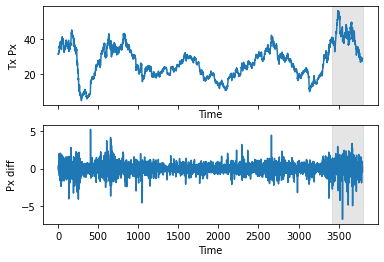

In [43]:
#Graph and highlight the test set

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)

ax1.plot(df['PX_LAST'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Tx Px')
ax1.axvspan(len(train), len(train)+len(test), color='#808080', alpha=0.2)

ax2.plot(df_diff)
ax2.set_xlabel('Time')
ax2.set_ylabel('Px diff')
ax2.axvspan(len(train), len(train)+len(test), color='#808080', alpha=0.2)

In [44]:
# def the models. Mean - Last Price - MA.
from statsmodels.tsa.statespace.sarimax import SARIMAX

def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    
    if method == 'mean':#NOT RUNNING
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'MA':
        pred_MA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(0,0,2))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_MA.extend(oos_pred)
            
        return pred_MA

In [45]:
#Save the results. Check what happened with the mean value.
pred_df = test.copy()

TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_MA = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'MA')

pred_df['pred_mean'] = pred_mean
pred_df['pred_last_value'] = pred_last_value
pred_df['pred_MA'] = pred_MA

pred_df.head()
# Where is it calling PX_LAST to the differenced series. Why mean is not calculating? (Bc of NaN values on Dataset??)

,PX_LAST,pred_mean,pred_last_value,pred_MA
3419,-1.23,NaN,-0.06,-0.014806
3420,1.00,NaN,-0.06,-0.000894
3421,0.16,NaN,1.00,-0.005697
3422,-2.72,NaN,1.00,0.020588
3423,0.71,NaN,-2.72,-0.046341


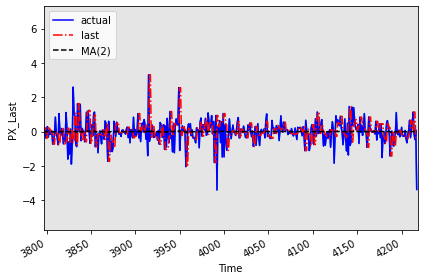

In [13]:
# GRaph all results. Don't know why other results are not showing up

fig, ax = plt.subplots()

ax.plot(df_diff['PX_LAST'])
ax.plot(pred_df['PX_LAST'], 'b-', label='actual')
#ax.plot(pred_df['pred_mean'], 'g:', label='mean')
ax.plot(pred_df['pred_last_value'], 'r-.', label='last')
ax.plot(pred_df['pred_MA'], 'k--', label='MA(2)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('PX_Last')

ax.axvspan(3797, 4218, color='#808080', alpha=0.2)

ax.set_xlim(3797, 4218)



fig.autofmt_xdate()
plt.tight_layout()